# STAC Demo Notebook

Welcome to the interactive notebook version of the STAC demo. This notebook demonstrates how to run the demo script, visualize results, and understand the workflow.

# STAC Demo Notebook
This notebook demonstrates the full STAC demo script with all its code components.

## Import Libraries
This cell imports the key Python libraries required for STAC data processing including pystac_client, stackstac, pandas, and geogif.

In [1]:
# Import required libraries
from pystac_client import Client
import stackstac
import pandas as pd
import geogif

## Connect to STAC endpoint
We now connect to the Thünen Earth Observation STAC endpoint and fetch available datat collections.

In [19]:
# Define the STAC API endpoint
STACK_ENDPOINT = "https://eodata.thuenen.de/stac/api/v1/"

# Open the STAC catalog using the defined endpoint
catalog = Client.open(STACK_ENDPOINT)

# Print all available collections for verification
[i for i in catalog.get_collections()]

[<CollectionClient id=crop-type-map-latest>,
 <CollectionClient id=crop-type-map-v202>,
 <CollectionClient id=crop-type-map-v302>,
 <CollectionClient id=mowing-events>,
 <CollectionClient id=winter-cover>]

## Search Collection with bounding box and timeframe
We define a bounding box and timeframe for our search. The bounding box is specified as a tuple of (min_lon, min_lat, max_lon, max_lat), and the timeframe is given in the format "YYYY-MM-DD/YYYY-MM-DD". With this, we can search for items in the [latest crop type mape collection](https://eodata.thuenen.de/collections/crop-type-map-latest) that fall within these geographic and temporal constraints.

In [26]:
# Define geographic bounding box and timeframe
bbox = (10.067037606, 52.191323852, 10.50465365, 52.375267045)
timeframe = "2017-01-01/2025-12-31"

# Select latest crop type map collection
collection = "crop-type-map-latest"

# Search the catalog for items within the specified bounds, collection, and datetime range
search = catalog.search(
    collections=collection,
    bbox=bbox,
    datetime=timeframe
)

# Retrieve all search results as a list of items
items = list(search.items())

items

[<Item id=crop-type-map-latest-2025>,
 <Item id=crop-type-map-latest-2024>,
 <Item id=crop-type-map-latest-2023>,
 <Item id=crop-type-map-latest-2022>,
 <Item id=crop-type-map-latest-2021>,
 <Item id=crop-type-map-latest-2020>,
 <Item id=crop-type-map-latest-2019>,
 <Item id=crop-type-map-latest-2018>,
 <Item id=crop-type-map-latest-2017>]

## Mosaic the found products
Using stackstac, we can mosaic the found items to a stack with a defined CRS, resolution, and extent. Since stackstac is using dask.arrays, no data is downloaded at that point.

In [23]:
# Create a mosaic stack from the retrieved items using stackstac
mosaic_stack = stackstac.stack(
    items=items,
    resolution=(10, 10),
    bounds_latlon=bbox,
    epsg=3035
).sel(band=["data"])

mosaic_stack

<xarray.DataArray 'stackstac-52dfd88cadc24163930206c61f5934cc' (time: 9,
                                                                band: 1,
                                                                y: 2059, x: 2996)> Size: 444MB
dask.array<getitem, shape=(9, 1, 2059, 2996), dtype=float64, chunksize=(1, 1, 1024, 1024), chunktype=numpy.ndarray>
Coordinates: (12/16)
  * time              (time) datetime64[ns] 72B 2017-07-01 ... 2025-07-01
    id                (time) <U25 900B 'crop-type-map-latest-2017' ... 'crop-...
  * band              (band) <U4 16B 'data'
  * x                 (x) float64 24kB 4.326e+06 4.326e+06 ... 4.356e+06
  * y                 (y) float64 16kB 3.252e+06 3.252e+06 ... 3.231e+06
    proj:geometry     (time) object 72B {'type': 'Polygon', 'coordinates': [[...
    ...                ...
    end_datetime      (time) <U20 720B '2017-12-31T00:00:00Z' ... '2025-12-31...
    proj:code         <U9 36B 'EPSG:3035'
    proj:shape        object 8B {90000, 66000}
    sci:doi           (time) <U23 828B '10.5281/zenodo.10640528' ... '10.5281...
    description       <U1547 6kB 'This dataset offers the **most comprehensiv...
    epsg              int64 8B 3035
Attributes:
    spec:        RasterSpec(epsg=3035, bounds=(4325560, 3231290, 4355520, 325...
    crs:         epsg:3035
    transform:   | 10.00, 0.00, 4325560.00|\n| 0.00,-10.00, 3251880.00|\n| 0....
    resolution:  10

## Inspect metadata
All metadata from the STAC collections and items are stored in the object and can be accessed, like, e.g., the class catalog of the crop type map.

In [27]:
# Display the crop type lookup table (LUT) from the mosaic stack metadata
crop_type_lut = mosaic_stack["raster:bands"].item()["categories"].items()
print(pd.DataFrame(list(crop_type_lut), columns=["Value", "Crop type"]))

   Value                 Crop type
0    200       Permanent grassland
1   1101              Winter wheat
2   1102             Winter barley
3   1103                Winter rye
4   1201             Spring barley
5   1202                Spring oat
6   1300                     Maize
7   1401                    Potato
8   1402                Sugar beet
9   1501           Winter rapeseed
10  1502                 Sunflower
11  1602      Cultivated grassland
12  1603                Vegetables
13  1611                      Peas
14  1612                Broad bean
15  1613                     Lupin
16  1614                       Soy
17  3001      Small woody features
18  3002  Other agricultural areas
19  3003               Fallow land
20  3004               Other areas
21  4001                 Grapevine
22  4002                      Hops
23  4003                   Orchard


## Compute and visualize
Only when the compute() function is used, exactly those data that fall into our spatiotemporal selection are downloaded and, in this example, animated as a GIF.

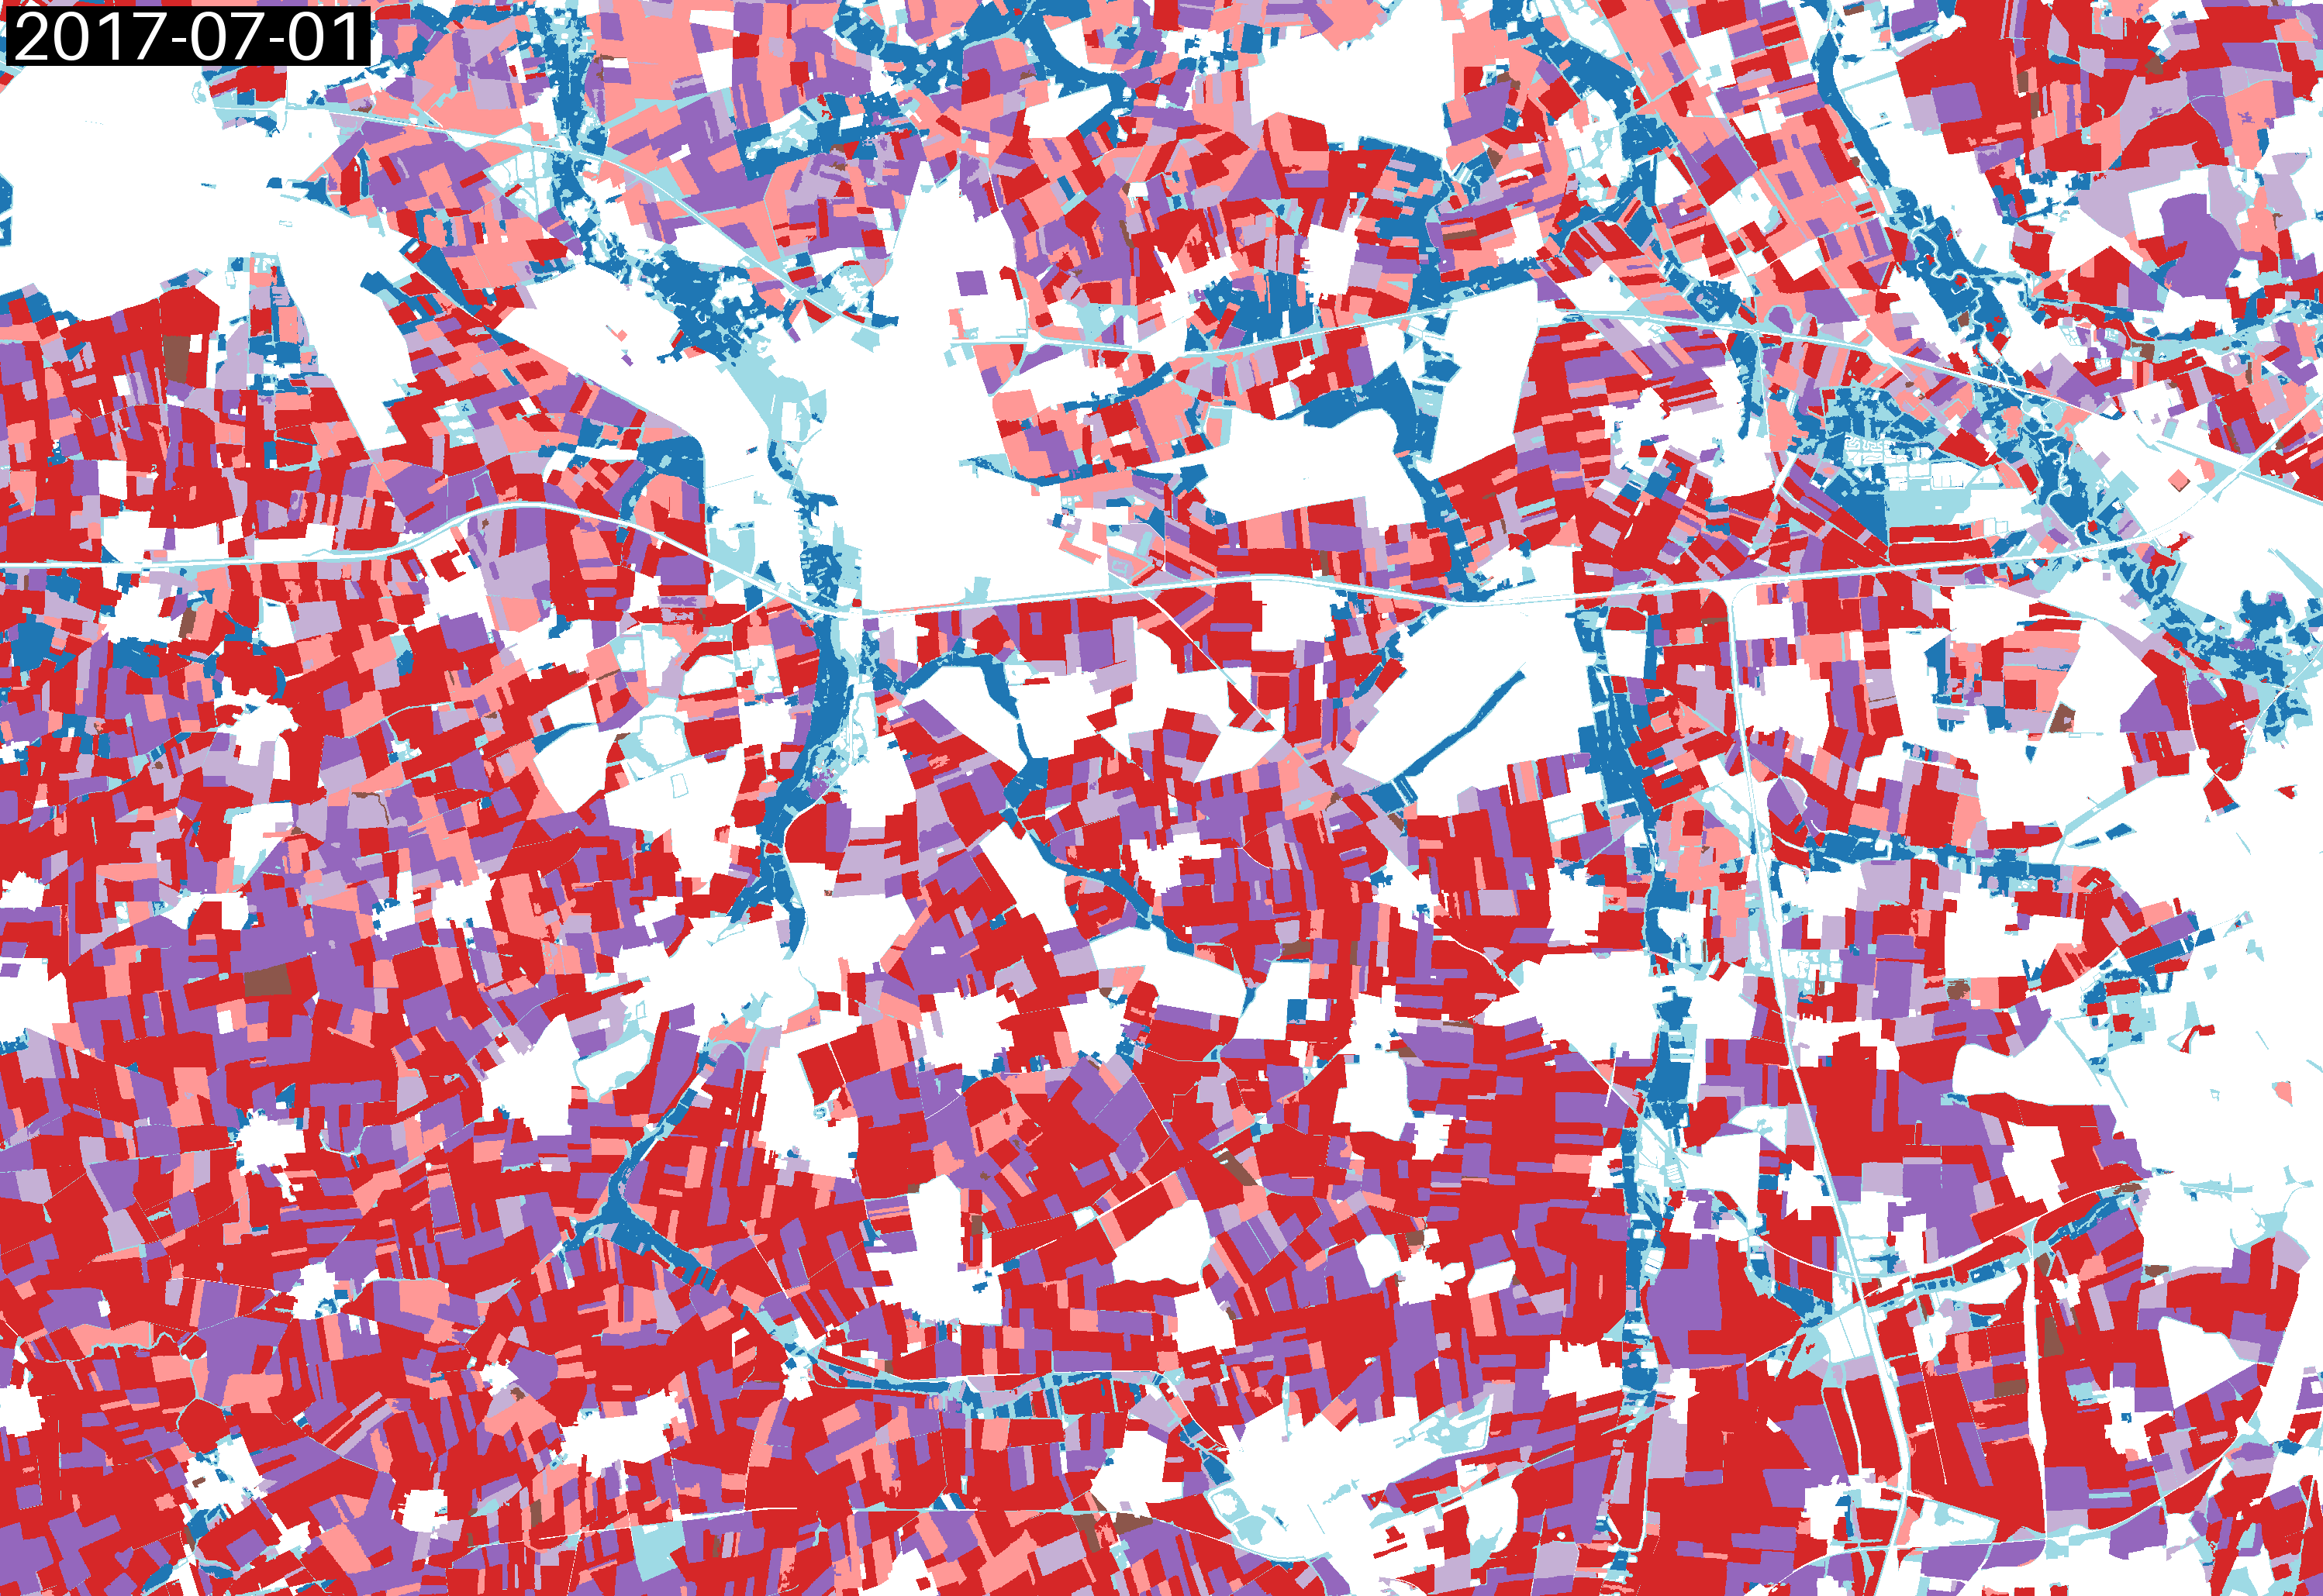

In [25]:
# Generate an animated GIF from the mosaic stack
geogif.dgif(mosaic_stack, fps=1, cmap="tab20").compute()